### Tutorial: Optimal Strategy Given a Fixed Observing Budget

In this simplest example, let's say you have a budget of 30 P1 (high priority) observations on the NEID spectrograph on the WIYN observatory on Kitt Peak in Arizona, and you want to spend them on a single target. Let's say you also have to plan around already-booked nights on the telescope. Finally, let's say your star is an exact copy of AU Mic. Given these constraints, how do you best allocate your budget to maximize the Fisher Information (or minimize the uncertainty) on the radial velocity semi-amplitude, K?


In [1]:
import numpy as np 
import scipy
print(np.__version__)
print(scipy.__version__)
import pandas as pd
import random
import astropy 
from numpy.linalg import inv, det, solve, cond
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib

import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
#from jax import random

from gaspery import calculate_fi, strategies, utils
from tinygp import kernels, GaussianProcess


1.23.4
1.9.3


In [2]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(params)

path = '/Users/chrislam/Desktop/gaspery/'

We take the target parameters (stellar mass, planet orbital period, estimated RV semi-amplitude (K), and the central transit crossing time), from Table 3 of Klein+ 2021 (https://academic.oup.com/mnras/article/502/1/188/6027693). We take the stellar correlated noise parameters (activity timescale, smoothing parameter, white and correlated noise amplitudes, and stellar rotation period) from the same source.

In [3]:
### Time to prep ### 

### target parameters
Mstar = 0.5 # Solar masses
p = 8.46 # orbital period, days
K = 850 # cm/s
T0 = 2458651.993 # central transit time, in BJD, on 19 June 2019
#m = 30 # Earth masses

### correlated noise parameters
Tau = 100/np.sqrt(2) # active region lifetime; days
eta = 0.4/np.sqrt(2) # 0.1, 0.3, 0.58, 0.9 # smoothing parameter
sigma_qp_rv = 47 * 1e2 # modified Jeffreys prior +11, -8 [cm/s]
sigma_wn_rv = 5 * 1e2 # [cm/s]
Prot = 4.86 # rotation period, days

params = [Tau, eta, Prot, sigma_qp_rv, sigma_wn_rv]
theta = [K, p, T0]

In [4]:
# calculate RV based on 30 Earth-mass planet, using Eqn 14 from Lovis & Fischer 2010 
#K = utils.calculate_rv(Mstar, m, p) * 1e2 # cm/s
#print(K)

As of this writing, it is currently 2/27/23, and the NOIRLab calendar for the 2023A semester (https://time-allocation.noirlab.edu/#/telescopes/classic-schedules/?telescopeId=3&semesterCode=2023A) says that the pre-booked nights on the telescope that we have to plan around are: 4/16-18, 4/20-21, the latter half of 4/22, 4/24-25, 5/13-15, 5/19-20, 6/18-19, the first half of 6/22, 6/24, the latter half of 6/25, 7/6-8, and 7/21. The calendar also says that the end of the observing semester is 7/23, which means any strategy must end by that day. 

Based on airmass.org or astroplan's determination of when in the year AU Mic is up at night, as well as the off nights prescribed above, let's start observing on the night of 5/21/23-5/22/23. We will use 10am UTC as our default observation time (3am MST) because that's roughly when the star is highest at that time of year -- in reality, we would ask to be scheduled in the latter half of the night. If only the former half of a night has been blocked off, we still go ahead and observe that night because we assume our exposure is short enough. 

In [24]:
from astropy.time import Time

# start time and date
start = '2023-05-22T10:00:00'
start = Time(start, format='isot', scale='utc').jd

# construct off nights, bracketing a "night" as 8pm to 6am MST, or 3am to 1pm UTC the next day
# night is divided into halves around 1am local. 

offs = [ ['2023-06-19T03:00:00', '2023-06-19T13:00:00'], 
        ['2023-06-20T03:00:00', '2023-06-20T13:00:00'],
       ['2023-06-23T03:00:00', '2023-06-23T08:00:00'],
       ['2023-06-25T03:00:00', '2023-06-25T13:00:00'],
       ['2023-06-26T08:00:00', '2023-06-26T13:00:00'],
       ['2023-07-07T03:00:00', '2023-07-07T13:00:00'],
       ['2023-07-08T03:00:00', '2023-07-08T13:00:00'],
       ['2023-07-09T03:00:00', '2023-07-09T13:00:00'],
       ['2023-07-22T03:00:00', '2023-07-22T13:00:00']]

#offs = []

t = Time(offs, format='isot', scale='utc')
offs = t.jd
print("offs: ", offs)

# stop observing because of end of season
stop = ['2023-07-24T03:00:00']
stop = Time(stop, format='isot', scale='utc').jd

n_obs = 30

offs:  [[2460114.625      2460115.04166667]
 [2460115.625      2460116.04166667]
 [2460118.625      2460118.83333333]
 [2460120.625      2460121.04166667]
 [2460121.83333333 2460122.04166667]
 [2460132.625      2460133.04166667]
 [2460133.625      2460134.04166667]
 [2460134.625      2460135.04166667]
 [2460147.625      2460148.04166667]]


Use a quasi-periodic Gaussian Process kernel from tinygp to model the correlated noise of the star.

In [6]:
# build covariance matrix, characterized by a correlated noise model of the stellar signal
kernel = kernels.ExpSineSquared(scale=Prot, gamma=1/(2*eta**2)) # first term of exponential
kernel *= kernels.ExpSquared(scale=Tau) # other term of exponential
kernel *= sigma_qp_rv**2 # multiply by scalar

Set up combinations of observing strategies to explore and calculate the Fisher Information and uncertainty on K. 

In [7]:
on_grid = np.linspace(1, 15, 15)
off_grid = np.linspace(0, 15, 16)

fi_ks = np.ones(len(on_grid)*len(off_grid)).reshape((len(on_grid),len(off_grid)))
sigma_ks = np.ones(len(on_grid)*len(off_grid)).reshape((len(on_grid),len(off_grid)))

Declare maximum possible observing baseline, beyond which all observing strategies terminate. 

In [8]:
baseline_tol = (stop - start)[0] # if I go past this, stop observing

In [9]:
print(baseline_tol)

62.708333333488554


In [10]:
strategy = strategies.Strategy(n_obs = n_obs, start = start, offs=offs, dropout=0.)
strat = np.array(strategy.on_vs_off(on=12, off=14, twice_flag=False))
print(strat[-1] - strat[0], strat, len(strat))

57.0 [2460086.91666667 2460087.91666667 2460088.91666667 2460089.91666667
 2460090.91666667 2460091.91666667 2460092.91666667 2460093.91666667
 2460094.91666667 2460095.91666667 2460096.91666667 2460097.91666667
 2460112.91666667 2460113.91666667 2460114.91666667 2460115.91666667
 2460116.91666667 2460117.91666667 2460118.91666667 2460119.91666667
 2460120.91666667 2460121.91666667 2460122.91666667 2460123.91666667
 2460138.91666667 2460139.91666667 2460140.91666667 2460141.91666667
 2460142.91666667 2460143.91666667] 30


In [11]:
strategy = strategies.Strategy(n_obs = n_obs, start = start, offs=[], dropout=0.)
strat = np.array(strategy.on_vs_off(on=12, off=14, twice_flag=False))
print(strat[-1] - strat[0], strat, len(strat))

63.0 [2460086.91666667 2460087.91666667 2460088.91666667 2460089.91666667
 2460090.91666667 2460091.91666667 2460092.91666667 2460093.91666667
 2460094.91666667 2460095.91666667 2460096.91666667 2460097.91666667
 2460112.91666667 2460113.91666667 2460114.91666667 2460115.91666667
 2460116.91666667 2460117.91666667 2460118.91666667 2460119.91666667
 2460120.91666667 2460121.91666667 2460122.91666667 2460123.91666667
 2460138.91666667 2460139.91666667 2460140.91666667 2460141.91666667
 2460142.91666667 2460143.91666667 2460144.91666667 2460145.91666667
 2460146.91666667 2460147.91666667 2460148.91666667 2460149.91666667] 36


Time to cook! We propose different observing strategies based on different combinations of "on" and "off" nights. The "on" parameter is how many consecutive nights we try to observe. The "off" parameter is how many consecutive nights we intentionally choose not to observe. The most common purpose for doing this is to extend the total observing baseline in order to squeeze out more phase coverage for the signal we're trying to observe. If an "on" night falls on a night that has already been pre-scheduled (in the "offs" list), we skip it and continue the pattern of "on"s and "off"s without restarting. We do this until we reach 30 observations. 

In [25]:
# instantiate Star object in order to feed covariance matrix with white/correlated noise
star = calculate_fi.Star(sigma_wn_rv = sigma_wn_rv, Tau = Tau, eta = eta, 
                         Prot = Prot, sigma_qp_rv = sigma_qp_rv)

# populate list of parameters to feed into cov_matrix_jax()
params = star.param_list()

# instantiate Planets object in order to feed Fisher Info calculation machinery
planet = calculate_fi.Planets(K = K, p = p, T0 = T0)

# populate list of parameters to feed into clam_jax_fim()
theta = planet.theta_list()

# explore different combinations of on and off nights and calculate FI and sigma_K for each
for enum_on, on in enumerate(tqdm(on_grid)):
    for enum_off, off in enumerate(off_grid):
    
        on, off = int(on), int(off)
        
        # build strategy time series  
        strategy = strategies.Strategy(n_obs = n_obs, start = start, offs=offs, dropout=0.)
        strat = np.array(strategy.on_vs_off(on=on, off=off, twice_flag=False))

        # if strategy is longer than baseline tolerance, don't bother with it
        if strat[-1] - strat[0] > baseline_tol:
            sigma_ks[enum_on][enum_off] = np.nan
            fi_ks[enum_on][enum_off] = np.nan

        else:
            # calculate covariance matrix
            sigma = star.cov_matrix_general(strat, kernel)

            # populate arguments for Fisher Info calculator
            args = np.array(strat), sigma, jnp.array(theta, dtype=float)

            # calculate FI
            fim = calculate_fi.clam_jax_fim(*args).block_until_ready()
            fi_ks[enum_on][enum_off] = fim[0][0]

            # invert FI matrix
            inv_fim = inv(fim)

            # top left element of matrix corresponds with RV semi-amplitude, K
            sigma_k = np.sqrt(inv_fim)[0][0]

            #print(f"sigma K for {m} Earth mass: ", sigma_k, " cm/s")
            #print(f"sigma K/K ratio for {m} Earth mass: ", sigma_k/K)

            sigma_ks[enum_on][enum_off] = sigma_k


  0%|                                                                                                                                                         | 0/15 [00:00<?, ?it/s]/var/folders/fm/fpkllzw93kq7c5y3zl98167m0000gn/T/ipykernel_1744/1115121130.py:44: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.79it/s]


Let's plot the uncertainty on K for all these different observing strategies. We don't plot a point where the strategy results in an observed baseline that takes us beyond the observing semester.

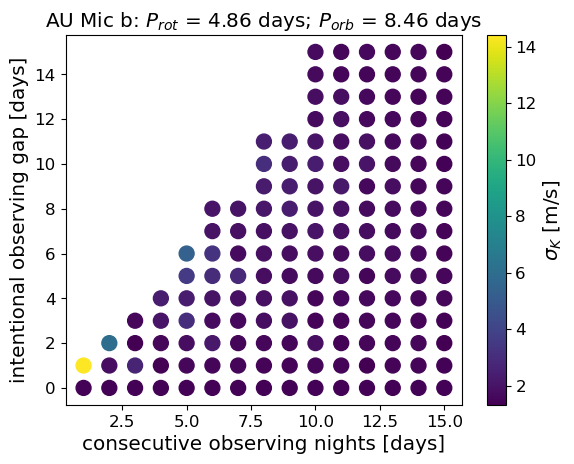

In [26]:
y, x = np.meshgrid(off_grid, on_grid)
plt.scatter(x, y, c=sigma_ks/100, s=115) # vmin=5, vmax=35

cbar = plt.colorbar()
cbar.ax.set_ylabel(r'$\sigma_K$ [m/s]')
plt.ylabel("intentional observing gap [days]")
plt.xlabel("consecutive observing nights [days]")
plt.title(r"AU Mic b: $P_{rot}$ = " + f"{Prot} days; " + "$P_{orb}$ = " + f"{p} days")
plt.show()

In [28]:
offs

array([[2460114.625     , 2460115.04166667],
       [2460115.625     , 2460116.04166667],
       [2460118.625     , 2460118.83333333],
       [2460120.625     , 2460121.04166667],
       [2460121.83333333, 2460122.04166667],
       [2460132.625     , 2460133.04166667],
       [2460133.625     , 2460134.04166667],
       [2460134.625     , 2460135.04166667],
       [2460147.625     , 2460148.04166667]])

In [23]:
strat

array([2460086.91666667, 2460087.91666667, 2460088.91666667,
       2460089.91666667, 2460090.91666667, 2460091.91666667,
       2460092.91666667, 2460093.91666667, 2460094.91666667,
       2460095.91666667, 2460096.91666667, 2460097.91666667,
       2460098.91666667, 2460099.91666667, 2460100.91666667,
       2460116.91666667, 2460117.91666667, 2460118.91666667,
       2460119.91666667, 2460120.91666667, 2460121.91666667,
       2460122.91666667, 2460123.91666667, 2460124.91666667,
       2460125.91666667, 2460126.91666667, 2460127.91666667,
       2460128.91666667, 2460129.91666667, 2460130.91666667])

In [27]:
strat

array([2460086.91666667, 2460087.91666667, 2460088.91666667,
       2460089.91666667, 2460090.91666667, 2460091.91666667,
       2460092.91666667, 2460093.91666667, 2460094.91666667,
       2460095.91666667, 2460096.91666667, 2460097.91666667,
       2460098.91666667, 2460099.91666667, 2460100.91666667,
       2460116.91666667, 2460117.91666667, 2460118.91666667,
       2460119.91666667, 2460120.91666667, 2460121.91666667,
       2460122.91666667, 2460123.91666667, 2460124.91666667,
       2460125.91666667, 2460126.91666667, 2460127.91666667,
       2460128.91666667, 2460129.91666667, 2460130.91666667])

As the plot shows, there's not much difference between most observing strategies in this case, although the color gradient suggests that the worst-performing allowed strategies are those near the threshold at which observing baselines start to become longer than the allowed timeframe. Of note, there are a few observing strategies that perform particularly poorly, such as {on: 1, off: 1}. Let's compare this strategy with a better-performing one (eg. {on: 3, off: 1}). 

#### Phase coverage

As in the minimum observations tutorial, let's phase fold the stellar signal and add it to the planet signal to get out the observed signal. We will use tinygp's GaussianProcess class to create a quasi-periodic Gaussian Process kernel and draw one (1) sample that we phase-fold, in order to illustrate the observational sampling over a realistic signal.

In [19]:
strat = np.array(strategy.on_vs_off(on=1, off=1, twice_flag=False))

In [22]:
gp = GaussianProcess(kernel, strat)
sample = gp.sample(jax.random.PRNGKey(4), shape=(1,))/100

Phase-fold the planet signal.

In [23]:
t_phase_folded = strat % p # phase fold support
y_phase_folded = np.array(calculate_fi.model_jax(t_phase_folded, [K, p, T0]))/100

When plotting, bin both the phase-folded (total) observed and putative planet signal.

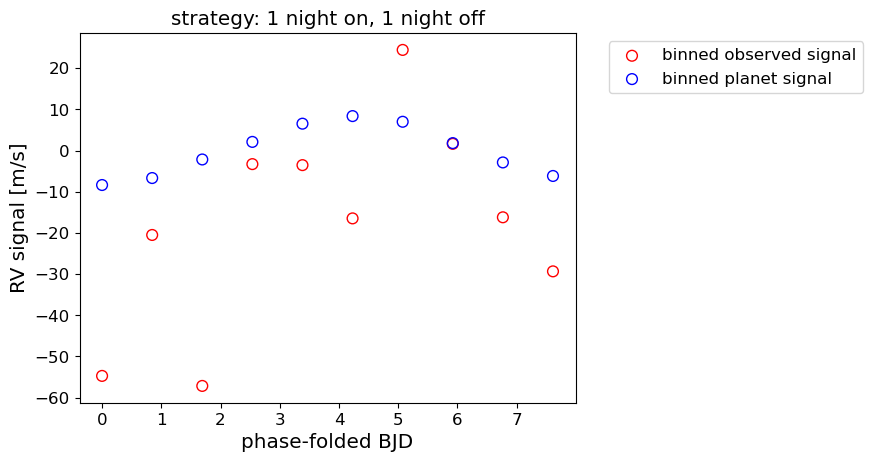

In [25]:
from scipy.stats import binned_statistic

# first, create fiducial model of the planet signal
y = calculate_fi.model_jax(strat, [theta[0], theta[1], theta[2]])/100

# bin the observed signal of planet + stellar signal, phase-folded by orbital period
bins = 10
mean_stat_observed = binned_statistic(strat % p, sample + y, 
                             statistic='mean', 
                             bins=bins, range=(0, p))

# bin the observed signal of just the planet signal, phase-folded by orbital period
bins = 10
mean_stat_planet = binned_statistic(strat % p, y, 
                             statistic='mean', 
                             bins=bins, range=(0, p))

#plt.scatter(strat % p, sample + y_phase_folded, label='observed signal', s=10)
plt.scatter(mean_stat_observed.bin_edges[:-1], mean_stat_observed.statistic, label='binned observed signal', s=60, 
            facecolors='none', edgecolors='r')
#plt.scatter(strat % p, y_phase_folded, label='putative planet signal', s=10)
plt.scatter(mean_stat_planet.bin_edges[:-1], mean_stat_planet.statistic, label='binned planet signal', s=60, 
            facecolors='none', edgecolors='blue')

plt.legend()
plt.xlabel('phase-folded BJD')
plt.ylabel('RV signal [m/s]')
plt.title('strategy: 1 night on, 1 night off')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

Let's try this with the better-performing strategy of 3 nights on, 1 night off.

In [26]:
strat = np.array(strategy.on_vs_off(on=3, off=1, twice_flag=False))

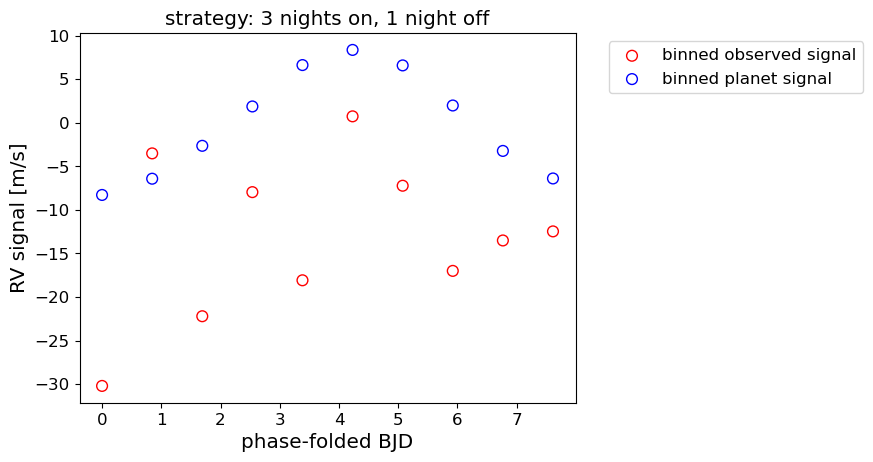

In [27]:
gp = GaussianProcess(kernel, strat)
sample = gp.sample(jax.random.PRNGKey(4), shape=(1,))/100

t_phase_folded = strat % p # phase fold support
y_phase_folded = np.array(calculate_fi.model_jax(t_phase_folded, [K, p, T0]))/100

from scipy.stats import binned_statistic

# first, create fiducial model of the planet signal
y = calculate_fi.model_jax(strat, [theta[0], theta[1], theta[2]])/100

# bin the observed signal of planet + stellar signal, phase-folded by orbital period
bins = 10
mean_stat_observed = binned_statistic(strat % p, sample + y, 
                             statistic='mean', 
                             bins=bins, range=(0, p))

# bin the observed signal of just the planet signal, phase-folded by orbital period
bins = 10
mean_stat_planet = binned_statistic(strat % p, y, 
                             statistic='mean', 
                             bins=bins, range=(0, p))

#plt.scatter(strat % p, sample + y_phase_folded, label='observed signal', s=10)
plt.scatter(mean_stat_observed.bin_edges[:-1], mean_stat_observed.statistic, label='binned observed signal', s=60, 
            facecolors='none', edgecolors='r')
#plt.scatter(strat % p, y_phase_folded, label='putative planet signal', s=10)
plt.scatter(mean_stat_planet.bin_edges[:-1], mean_stat_planet.statistic, label='binned planet signal', s=60, 
            facecolors='none', edgecolors='blue')

plt.legend()
plt.xlabel('phase-folded BJD')
plt.ylabel('RV signal [m/s]')
plt.title('strategy: 3 nights on, 1 night off')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

Noting the scale of the y-axes, in the former case (on: 1, off: 1), the correlated noise drowns the putative planet signal, at least relative to the strategy of {on: 3, off: 1}.